In [1]:
import warnings
warnings.filterwarnings("ignore", append=True)

import os
import cv2
import torch
import random
import numpy as np
import supervision as sv

from PIL import Image
from model import DeTr
from tqdm import tqdm
from functools import partial
from dataset import CocoDetection
from supervision import Detections
from IPython.display import display
from coco_eval import CocoEvaluator
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor, logging
from utils import prepare_for_coco_detection, collate_fn

logging.set_verbosity_error()

In [2]:
# parameters
BEST_CHECKPOINT = "checkpoints/best-epoch=19-validation_loss=1.3018.ckpt"
TEST_DATASET_PATH = "datasets/test"
CONFIDENCE_TRESHOLD = 0.7
IOU_TRESHOLD = 0.5

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PRETRAINED_MODEL = "facebook/detr-resnet-50"

image_processor = DetrImageProcessor.from_pretrained(PRETRAINED_MODEL)
model = DeTr.load_from_checkpoint(checkpoint_path=BEST_CHECKPOINT, map_location=DEVICE)
test_dataset = CocoDetection(image_directory_path=TEST_DATASET_PATH, image_processor=image_processor)
test_dataloader = DataLoader(
    dataset=test_dataset,
    collate_fn=partial(collate_fn, image_processor=image_processor),
    batch_size=4)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
model.eval()
print("Running evaluation...")
evaluator = CocoEvaluator(coco_gt=test_dataset.coco, iou_types=["bbox"])

for idx, batch in enumerate(tqdm(test_dataloader)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = batch["labels"]

    with torch.no_grad():
       outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, threshold=0.0, target_sizes=target_sizes)

    # map image_id → prediction
    predictions = {
        target["image_id"].item(): output
        for target, output in zip(labels, results)
    }

    coco_predictions = prepare_for_coco_detection(predictions)
    if len(coco_predictions) > 0:
        evaluator.update(coco_predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


100%|██████████| 5/5 [01:07<00:00, 13.44s/it]

Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

Image 7
GROUND TRUTH


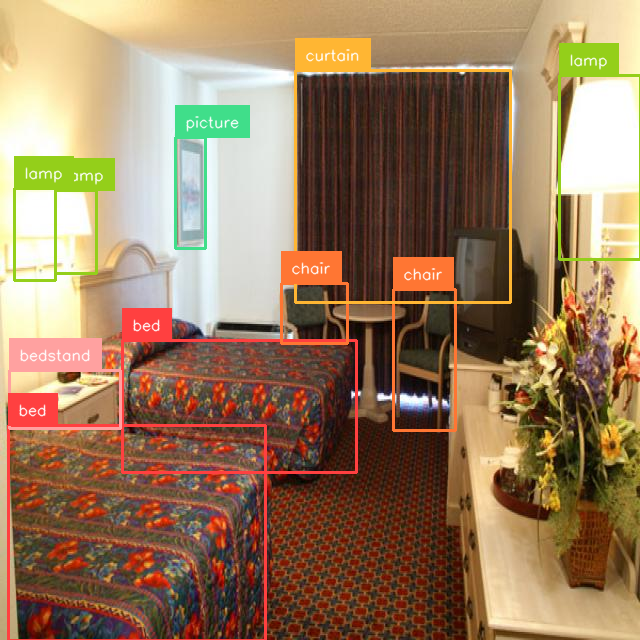

PREDICTION


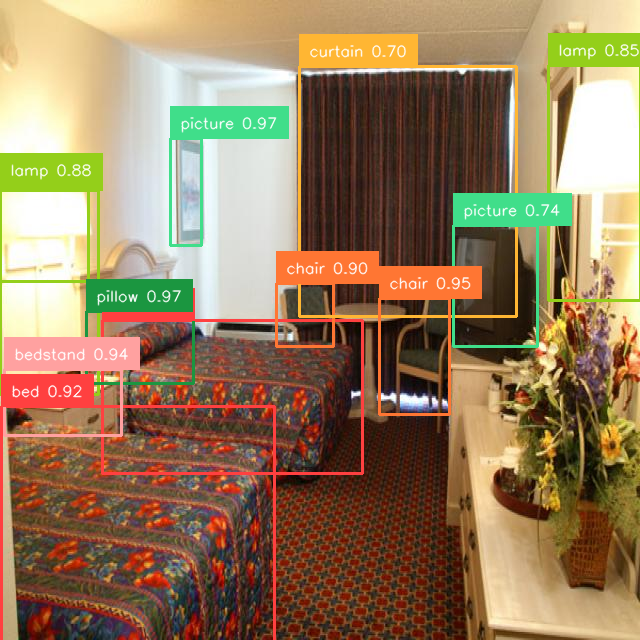

In [7]:
# select random image
image_ids = test_dataset.coco.getImgIds()
image_id = random.choice(image_ids)
print("Image {}".format(image_id))

# load image and annotations
image = test_dataset.coco.loadImgs(image_id)[0]
annotations = test_dataset.coco.imgToAnns[image_id]
image_path = os.path.join(test_dataset.root, image["file_name"])
image = cv2.imread(image_path)

# from coco annotations to supervision detections
boxes = []
class_ids = []
for ann in annotations:
    boxes.append(ann["bbox"])
    class_ids.append(ann["category_id"])

xyxy = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])   # [x, y, width, height]
detections = Detections(xyxy=xyxy, class_id=np.array(class_ids))

# annotate boxes and labels
categories = test_dataset.coco.cats
id2label = {k: v["name"] for k, v in categories.items()}
labels = [f"{id2label[class_id]}" for class_id in detections.class_id]

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
frame = box_annotator.annotate(scene=image.copy(), detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)

# display
print("GROUND TRUTH")
img_rgb = frame[:, :, ::-1]     # BGR → RGB
pil_img = Image.fromarray(img_rgb.astype(np.uint8))
display(pil_img)

# inference
model.eval()
with torch.no_grad():
    # preprocess
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    # prediction
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]])
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# remove duplicates
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)

# annotate boxes and labels
labels = [
    f"{id2label[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

frame = box_annotator.annotate(scene=image.copy(), detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)

#display
print("PREDICTION")
img_rgb = frame[:, :, ::-1]     # BGR → RGB
pil_img = Image.fromarray(img_rgb.astype(np.uint8))
display(pil_img)